In [1]:
import argparse
import functools as ft
import itertools as it
from localscope import localscope
import logging
logging.basicConfig(level='WARNING')
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import emcee
import shedding
from scipy import stats, special
from tqdm import tqdm
import sys
import pickle

mpl.rcParams['figure.dpi'] = 144

args = os.environ.get('ARGS', "-i  -s 0 -f general workspace/test/emcee").split()
print(args)
parser = argparse.ArgumentParser()
# Positional
parser.add_argument('parametrisation', type=shedding.Parametrisation, 
                    help='parametrisation to use')
parser.add_argument('basedir')

# Keyword
parser.add_argument('--inflated', '-i', action='store_true', 
                    help='whether to use a zero-inflated model')
parser.add_argument('--temporal', '-t', action='store_true', 
                    help='whether to use a time-dependent model')
parser.add_argument('--force', '-f', action='store_true', 
                    help='force regeneration of samples')
parser.add_argument('--seed', '-s', type=int, help='random number generator seed')
parser.add_argument('--nwalkers', '-w', type=int, default=500, help='number of walkers')
parser.add_argument('--nwarmup', type=int, default=250, help='number of warmup steps')
parser.add_argument('--nsteps', '-n', type=int, default=10000, 
                    help='number of steps after warmup')
args = parser.parse_args(args)
os.makedirs(args.basedir, exist_ok=True)
args

['-i', '-s', '0', '-f', 'general', 'workspace/test/emcee']


Namespace(basedir='workspace/test/emcee', force=True, inflated=True, nsteps=10000, nwalkers=500, nwarmup=250, parametrisation=<Parametrisation.GENERAL: 'general'>, seed=0, temporal=False)

Load data

In [2]:
# Load and flatten some of the datasets
datasets = [
    'Woelfel2020', 
    'Lui2020', 
    'Han2020',
]
if not args.temporal:
    datasets.append('Wang2020')
    
datasets = shedding.load_datasets(datasets, 'publications/')
data = shedding.flatten_datasets(datasets, loq_fill_value=-99)
print(f'Number of patients: {data["num_patients"]}')
print(f'Number of patients with one or more positive samples: '
      f'{(data["num_positives_by_patient"] > 0).sum()}')
print(f'Number of samples: {data["num_samples"]}')
print(f'Number of positive samples: {data["positive"].sum()}')

model = shedding.Model(data['num_patients'], parametrisation=args.parametrisation, inflated=args.inflated,
                       temporal=args.temporal)
print(f'Number of parameters: {model.size}')

Number of patients: 36
Number of patients with one or more positive samples: 27
Number of samples: 148
Number of positive samples: 104
Number of parameters: 42


In [39]:
transform = shedding.DefaultTransformation()
        
def evaluate_log_joint(x, model, data):
    values = shedding.vector_to_values(model.parameters, x)
    jac = transform.jacobianlogdet(values)
    values = transform(values)
    return model.evaluate_log_joint(values, data) + jac

np.random.seed(args.seed)
vector = model.sample_params_from_vector(np.random.uniform(size=model.size))
values = shedding.vector_to_values(model.parameters, vector)
transformed = transform.inverse(values)
vector = shedding.values_to_vector(model.parameters, transformed)
values, evaluate_log_joint(vector, model, data)

({'population_loc': array(13.68338905),
  'population_scale': array(2.08408374),
  'patient_scale': array(1.38902136),
  'patient_mean': array([3.18402448e+05, 1.28094050e+05, 6.19559650e+05, 1.43560782e+05,
         3.22288336e+06, 6.94338226e+06, 9.04974599e+04, 1.56455414e+06,
         2.84866384e+05, 3.72816654e+05, 4.37878429e+06, 3.34019117e+02,
         6.53457397e+02, 5.39104277e+00, 2.06276984e+06, 1.43191490e+06,
         2.70980813e+06, 9.10232443e+06, 1.64326067e+06, 1.73412384e+05,
         1.45414548e+06, 1.78559271e+03]),
  'population_shape': array(1.57531585),
  'patient_shape': array(0.22906356),
  'rho': array(0.94466892),
  'slope': array(0.06874652)},
 -2228.513931286335)

In [40]:
n_walkers = args.nwalkers
n_params = model.size
x0 = np.random.normal(0, 0.05, size=(n_walkers, n_params))
sampler = emcee.EnsembleSampler(n_walkers, n_params, evaluate_log_joint, args=(model, data))

In [41]:
n_steps = args.nwarmup
num_negative = 0

with tqdm() as progress:
    while True:
        result = sampler.run_mcmc(x0, n_steps)
        logprob_trace = sampler.get_log_prob().mean(axis=1)
        delta = logprob_trace[-1] - logprob_trace[0]
        print(f'Log prob changed by {delta} from {logprob_trace[0]} to {logprob_trace[-1]}')
        x0 = sampler.get_chain()[-1]

        if delta < 0:
            num_negative += 1
        else:
            num_negative = 0

        # Demand three consecutive negative changes (should only ever happen in equilibrium)
        if num_negative >= 3:
            break

        sampler.reset()
        progress.update()

/Users/till/git/shedding/shedding/model.py:863: RuntimeWarning: overflow encountered in gengamma_lpdf
  result += gengamma_lpdf(values['population_shape'], values['population_loc'],
/Users/till/git/shedding/shedding/model.py:646: RuntimeWarning: overflow encountered in gengamma_lpdf
  lxdf = gengamma_lpdf(q, mu, sigma, data['loadln'], where=data['positive'])


Log prob changed by 311474839.1525409 from -311476343.1194075 to -1503.9668665290742
Log prob changed by 52.970415130689844 from -1503.5326250837693 to -1450.5622099530794
Log prob changed by 69.47675669469072 from -1450.3595023827156 to -1380.882745688025
Log prob changed by 33.82466708224911 from -1380.8361369564366 to -1347.0114698741875
Log prob changed by 40.38296632460879 from -1346.9006587919937 to -1306.517692467385
Log prob changed by 5.218374158647748 from -1306.564161963121 to -1301.3457878044733
Log prob changed by 2.589929345489736 from -1301.5706102205638 to -1298.980680875074
Log prob changed by 0.7672171130714105 from -1298.932119840137 to -1298.1649027270655
Log prob changed by 0.740737346657852 from -1298.170495415924 to -1297.4297580692662
Log prob changed by 0.24522740113980035 from -1297.499926295797 to -1297.2546988946572
Log prob changed by 0.019298155462365685 from -1297.184418399829 to -1297.1651202443666
Log prob changed by -0.23477429476088219 from -1297.1967

In [44]:
n_steps = args.nsteps
sampler.reset()
result = sampler.run_mcmc(x0, n_steps // 10, progress=True, thin_by=10)

  0%|          | 30/10000 [00:05<32:43,  5.08it/s]Traceback (most recent call last):
  File "/Users/till/.pyenv/versions/3.8.1/envs/shedding/lib/python3.8/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-39-ccf5249dd904>", line 7, in evaluate_log_joint
    return model.evaluate_log_joint(values, data) + jac
  File "/Users/till/git/shedding/shedding/model.py", line 513, in _augment_wrapper
    return func(self, values, *args, **kwargs)
  File "/Users/till/git/shedding/shedding/model.py", line 865, in evaluate_log_joint
    return result + self.evaluate_log_likelihood(values, data)
  File "/Users/till/git/shedding/shedding/model.py", line 513, in _augment_wrapper
    return func(self, values, *args, **kwargs)
  File "/Users/till/git/shedding/shedding/model.py", line 667, in evaluate_log_likelihood
    patient_contrib = self._evaluate_patient_log_likelihood(values, data) + \
  File "/Users/till/git/shedding/shed

emcee: Exception while calling your likelihood function:
  params: [16.11701387  0.87861897  0.91410265 18.07259896 16.27098401 17.72742667
 18.75971445 16.15671775 16.37797739 14.2348495  12.14481856 15.93692591
 16.21166146 17.8657753  17.98965255 15.47533465 16.28748592 15.61332074
 14.08946704 16.19934363 23.39578263 15.77098838 16.35120351 16.54139765
 22.91323401 -3.24500091 -0.18702007  2.7815642  -0.4337333 ]
  args: (<shedding.model.Model object at 0x117878d30>, {'loq': array([ 100.        ,  100.        ,  100.        ,  100.        ,
        100.        ,  100.        ,  100.        ,  100.        ,
        100.        ,  100.        ,  100.        ,  100.        ,
        100.        ,  100.        ,  100.        ,  100.        ,
        100.        ,  100.        ,  100.        ,  100.        ,
        100.        ,  100.        ,  100.        ,  100.        ,
        100.        ,  100.        ,  100.        ,  100.        ,
        100.        ,  100.        ,  100.     

KeyboardInterrupt: 

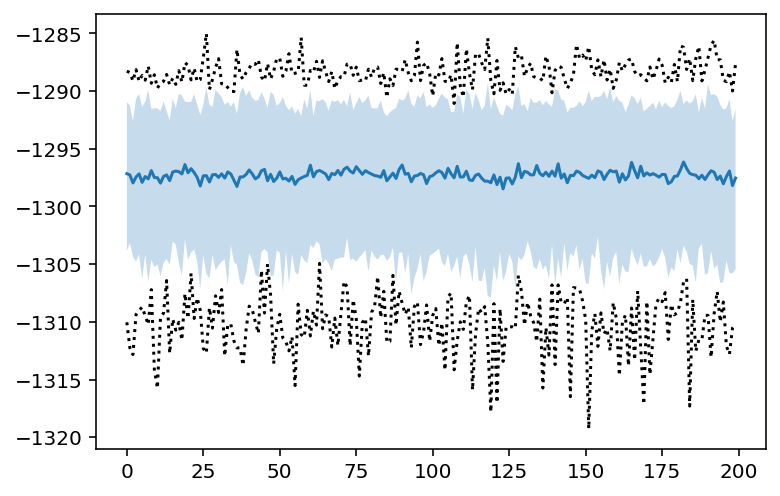

In [30]:
logprob = sampler.get_log_prob()
fig, ax = plt.subplots()
line, = ax.plot(logprob.mean(axis=1))
ax.fill_between(np.arange(len(logprob)), *np.percentile(logprob, [5, 95], axis=1), alpha=.25)
ax.plot(logprob.min(axis=1), color='k', ls=':')
ax.plot(logprob.max(axis=1), color='k', ls=':')

In [32]:
samples = shedding.vector_to_values(model.parameters, sampler.get_chain())
transformed = transform(dict(samples))

with open(os.path.join(args.basedir, 'samples.pkl'), 'wb') as fp:
    pickle.dump({
        'samples': transformed,
        'log_prob': sampler.get_log_prob(),
        'model': model,
        'data': data,
    }, fp)

array([7.46517627e+07, 1.08267444e+09, 1.45022996e+11])

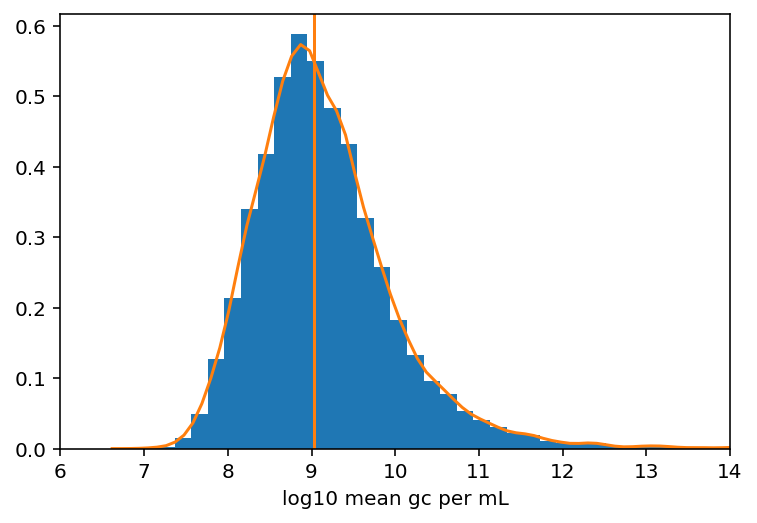

In [33]:
x = np.log10(model.evaluate_statistic(transformed, 'mean').ravel())
if 'rho' in transformed:
    x += np.log10(transformed['rho'].ravel())
plt.hist(x, density=True, bins=50)
plt.axvline(np.median(x), color='C1')
shedding.plot_kde(x, numlin=100)
plt.xlim(6, 14)
plt.xlabel('log10 mean gc per mL')
10 ** np.percentile(x, [2.5, 50, 97.5])

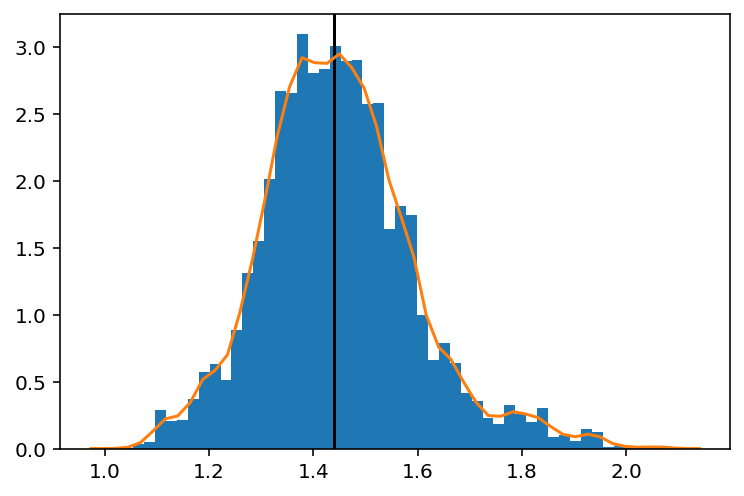

In [11]:
halflife = -np.log(2)/transformed['slope'].ravel()
plt.hist(halflife, bins=50, density=True)
plt.axvline(np.median(halflife), color='k')
np.percentile(halflife, [2.5, 50, 97.5]) * 24
shedding.plot_kde(halflife)

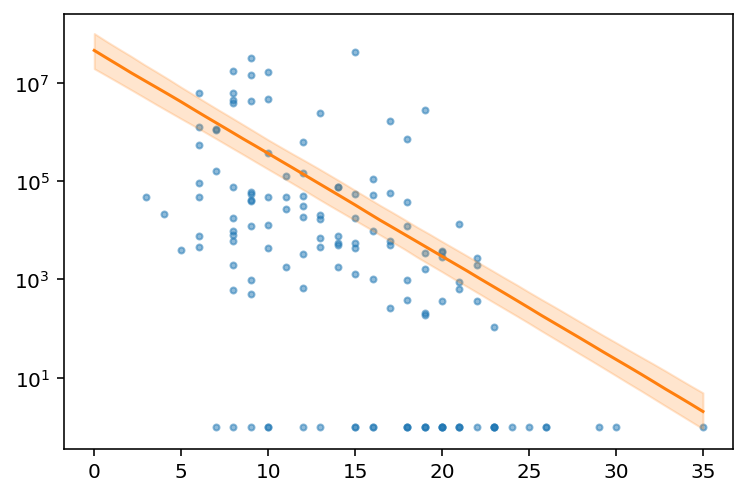

In [12]:
fig, ax = plt.subplots()

x = data['day']
y = np.where(data['positive'], data['load'], 1)


ax.scatter(x, y, alpha=.5, marker='.')

lin = np.linspace(0, 35)
y = transformed['population_loc']
# y = np.log(shedding.gengamma_mean(transformed['population_shape'], transformed['population_loc'], 
#                                   transformed['population_scale']))
ys = np.exp((y[..., None] + transformed['slope'] [..., None] * lin).reshape((-1, len(lin))))

y = np.median(ys, axis=0)
l, u = np.percentile(ys, [25, 75], axis=0)
line, = ax.plot(lin, y, color='C1')
ax.fill_between(lin, l, u, color=line.get_color(), alpha=.2)

ax.set_yscale('log')

(array([2.91424349e-02, 5.82848699e-03, 4.37136524e-02, 6.70276003e-02,
        9.32557918e-02, 3.00167080e-01, 4.19651063e-01, 3.96337115e-01,
        7.66446039e-01, 9.35472161e-01, 1.08701282e+00, 1.49500691e+00,
        2.41007937e+00, 3.33098031e+00, 4.26936672e+00, 6.78144461e+00,
        7.77811588e+00, 9.45963438e+00, 1.02115092e+01, 8.40467823e+00]),
 array([0.65676814, 0.67392525, 0.69108236, 0.70823947, 0.72539659,
        0.7425537 , 0.75971081, 0.77686792, 0.79402503, 0.81118214,
        0.82833925, 0.84549636, 0.86265348, 0.87981059, 0.8969677 ,
        0.91412481, 0.93128192, 0.94843903, 0.96559614, 0.98275326,
        0.99991037]),
 <BarContainer object of 20 artists>)

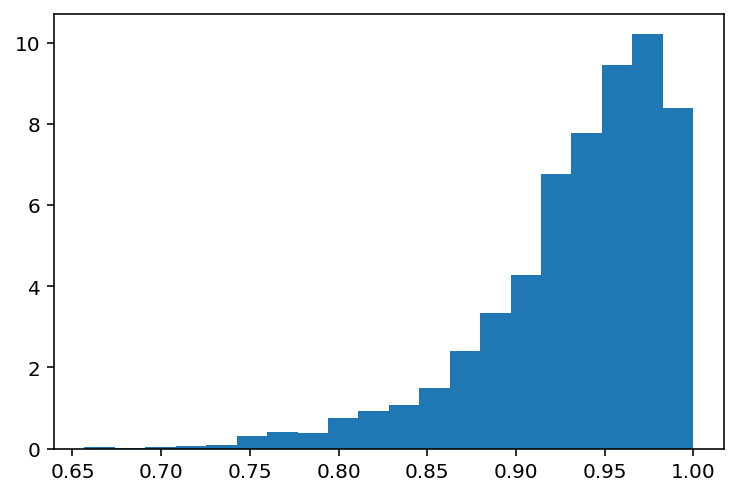

In [13]:
plt.hist(transformed['rho'].ravel(), density=True, bins=20)